In [1]:
pip install keras keras-cv tensorflow numpy pandas matplotlib tqdm joblib opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install jax jaxlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Set the Environment and Import Libraries

import os
os.environ["KERAS_BACKEND"] = "jax"  

# Core libraries
import keras
import keras_cv
import tensorflow as tf
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import joblib
import cv2

In [6]:
# Define the root directory and data directories

ROOT_DIR = "C:/Users/ASUS/Downloads/Model Training"
TRAIN_DIR = os.path.join(ROOT_DIR, "train")
TEST_DIR = os.path.join(ROOT_DIR, "test")
VAL_DIR = os.path.join(ROOT_DIR, "val")
MODEL_SAVE_DIR = "C:/Users/ASUS/Downloads/Model Training/model"

In [7]:
# Create DataFrames to organize the image data

def create_dataframe(directory):
    data = []
    # Iterate over the subdirectories 0 and 1
    for label, subdir in enumerate(["0", "1"]):
        # Get the full path of the current subdirectory
        subdir_path = os.path.join(directory, subdir)
        # Iterate over the files in the subdirectory
        for filename in os.listdir(subdir_path):
            # Check if the file has an image extension
            if filename.endswith((".png", ".jpg", ".jpeg")):
                # Create the full path of the file
                file_path = os.path.join(subdir_path, filename)
                # Append the file path and label to the list
                data.append((file_path, label))
    
    # Create a DataFrame from the list of file paths and labels
    df = pd.DataFrame(data, columns=["file_path", "label"])
    return df

# Create DataFrames for each set
train_df = create_dataframe(TRAIN_DIR)
test_df = create_dataframe(TEST_DIR)
val_df = create_dataframe(VAL_DIR)

# Save DataFrames to CSV (optional)
train_df.to_csv(os.path.join(ROOT_DIR, "train.csv"), index=False)
test_df.to_csv(os.path.join(ROOT_DIR, "test.csv"), index=False)
val_df.to_csv(os.path.join(ROOT_DIR, "val.csv"), index=False)

# Convert labels to strings
train_df["label"] = train_df["label"].astype(str)
test_df["label"] = test_df["label"].astype(str)
val_df["label"] = val_df["label"].astype(str)

# Check class distribution
print("Training set class distribution:")
print(train_df["label"].value_counts())
print("\nValidation set class distribution:")
print(val_df["label"].value_counts())
print("\nTest set class distribution:")
print(test_df["label"].value_counts())

Training set class distribution:
label
0    5293
1    3328
Name: count, dtype: int64

Validation set class distribution:
label
0    3539
1    2208
Name: count, dtype: int64

Test set class distribution:
label
0    1754
1    1120
Name: count, dtype: int64


In [8]:
# Define the preprocessing function for the retinal images

def custom_preprocessing(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(gray_image, (65, 65), 0)
    
    # Find the pixel with the highest intensity value
    max_intensity_pixel = np.unravel_index(np.argmax(blurred_image), blurred_image.shape)
    
    # Define the radius for the circle
    radius = 200 // 2
    
    # Get the x and y coordinates for cropping the image
    x = max_intensity_pixel[1] - radius
    y = max_intensity_pixel[0] - radius
    
    # Create a mask for the circle
    mask = np.zeros_like(image)
    cv2.circle(mask, (x + radius, y + radius), radius, (255, 255, 255), -1)
    
    # Apply the mask to the original image
    roi_image = cv2.bitwise_and(image, mask)
    
    # Split the green channel
    green_channel = roi_image[:, :, 1]
    
    # Apply histogram equalization
    clahe_op = cv2.createCLAHE(clipLimit=2)
    roi_image = clahe_op.apply(green_channel)
    
    # Reshape to 3 channels for model input
    roi_image = cv2.cvtColor(roi_image, cv2.COLOR_GRAY2RGB)
    
    return roi_image

In [9]:
# Create data generators with augmentation to improve model performance

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data generator for training images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Define the data generators for validation and test images
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define the batch size
batch_size = 32

# Create the data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='label',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 8621 validated image filenames belonging to 2 classes.
Found 5747 validated image filenames belonging to 2 classes.
Found 2874 validated image filenames belonging to 2 classes.


In [10]:
# Build the CNN Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Create a sequential model
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='binary_crossentropy', 
    metrics=['binary_accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Display model summary
model.summary()

C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      58,982,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,206,657 (225.86 MB)

 Trainable params: 59,206,657 (225.86 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Add callbacks to prevent overfitting and improve training

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    os.path.join(ROOT_DIR, 'best_model.h5'),
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, checkpoint]

In [12]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    callbacks=callbacks,
    verbose=1
)

# Save training history
import pickle
with open(os.path.join(ROOT_DIR, 'training_history.pkl'), 'wb') as file:
    pickle.dump(history.history, file)

C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - auc: 0.6294 - binary_accuracy: 0.6374 - loss: 0.6431 - precision: 0.5950 - recall: 0.2781

C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_auc improved from -inf to 0.72963, saving model to C:/Users/ASUS/Downloads/Model Training\best_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 2270s 8s/step - auc: 0.6295 - binary_accuracy: 0.6375 - loss: 0.6430 - precision: 0.5953 - recall: 0.2782 - val_auc: 0.7296 - val_binary_accuracy: 0.7070 - val_loss: 0.5823 - val_precision: 0.8267 - val_recall: 0.3003 - learning_rate: 1.0000e-04
Epoch 2/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - auc: 0.7086 - binary_accuracy: 0.6998 - loss: 0.5927 - precision: 0.7155 - recall: 0.3744
Epoch 2: val_auc improved from 0.72963 to 0.75586, saving model to C:/Users/ASUS/Downloads/Model Training\best_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 2109s 8s/step - auc: 0.7087 - binary_accuracy: 0.6998 - loss: 0.5927 - precision: 0.7155 - recall: 0.3744 - val_auc: 0.7559 - val_binary_accuracy: 0.7400 - val_loss: 0.5470 - val_precision: 0.7767 - val_recall: 0.4538 - learning_rate: 1.0000e-04
Epoch 3/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - auc: 0.7519 - binary_accuracy: 0.7296 - loss: 0.5563 - precision: 0.7487 - recall: 0.4739
Epoch 3: val_auc improved from 0.75586 to 0.80343, saving model to C:/Users/ASUS/Downloads/Model Training\best_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 2130s 8s/step - auc: 0.7519 - binary_accuracy: 0.7296 - loss: 0.5564 - precision: 0.7487 - recall: 0.4738 - val_auc: 0.8034 - val_binary_accuracy: 0.7465 - val_loss: 0.5188 - val_precision: 0.7895 - val_recall: 0.4638 - learning_rate: 1.0000e-04
Epoch 4/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - auc: 0.7576 - binary_accuracy: 0.7389 - loss: 0.5440 - precision: 0.7622 - recall: 0.4541
Epoch 4: val_auc improved from 0.80343 to 0.81362, saving model to C:/Users/ASUS/Downloads/Model Training\best_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 2168s 8s/step - auc: 0.7576 - binary_accuracy: 0.7389 - loss: 0.5440 - precision: 0.7622 - recall: 0.4541 - val_auc: 0.8136 - val_binary_accuracy: 0.7515 - val_loss: 0.5136 - val_precision: 0.8085 - val_recall: 0.4629 - learning_rate: 1.0000e-04
Epoch 5/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - auc: 0.7660 - binary_accuracy: 0.7376 - loss: 0.5373 - precision: 0.7636 - recall: 0.4502
Epoch 5: val_auc improved from 0.81362 to 0.81711, saving model to C:/Users/ASUS/Downloads/Model Training\best_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 2175s 8s/step - auc: 0.7660 - binary_accuracy: 0.7376 - loss: 0.5373 - precision: 0.7636 - recall: 0.4503 - val_auc: 0.8171 - val_binary_accuracy: 0.7555 - val_loss: 0.5039 - val_precision: 0.8735 - val_recall: 0.4253 - learning_rate: 1.0000e-04
Epoch 6/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - auc: 0.7806 - binary_accuracy: 0.7369 - loss: 0.5309 - precision: 0.7570 - recall: 0.4935
Epoch 6: val_auc improved from 0.81711 to 0.82352, saving model to C:/Users/ASUS/Downloads/Model Training\best_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 2142s 8s/step - auc: 0.7806 - binary_accuracy: 0.7370 - loss: 0.5309 - precision: 0.7571 - recall: 0.4935 - val_auc: 0.8235 - val_binary_accuracy: 0.7668 - val_loss: 0.4795 - val_precision: 0.7969 - val_recall: 0.5276 - learning_rate: 1.0000e-04
Epoch 7/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - auc: 0.7906 - binary_accuracy: 0.7510 - loss: 0.5132 - precision: 0.7714 - recall: 0.5069
Epoch 7: val_auc improved from 0.82352 to 0.82899, saving model to C:/Users/ASUS/Downloads/Model Training\best_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 2233s 8s/step - auc: 0.7906 - binary_accuracy: 0.7510 - loss: 0.5132 - precision: 0.7714 - recall: 0.5069 - val_auc: 0.8290 - val_binary_accuracy: 0.7634 - val_loss: 0.4751 - val_precision: 0.7849 - val_recall: 0.5290 - learning_rate: 1.0000e-04
Epoch 8/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - auc: 0.7977 - binary_accuracy: 0.7546 - loss: 0.5079 - precision: 0.7729 - recall: 0.5222
Epoch 8: val_auc did not improve from 0.82899
270/270 ━━━━━━━━━━━━━━━━━━━━ 2198s 8s/step - auc: 0.7977 - binary_accuracy: 0.7546 - loss: 0.5079 - precision: 0.7729 - recall: 0.5221 - val_auc: 0.8156 - val_binary_accuracy: 0.7411 - val_loss: 0.5403 - val_precision: 0.9455 - val_recall: 0.3460 - learning_rate: 1.0000e-04
Epoch 9/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - auc: 0.7969 - binary_accuracy: 0.7618 - loss: 0.5066 - precision: 0.7927 - recall: 0.5125
Epoch 9: val_auc improved from 0.82899 to 0.85228, saving model to C:/Users/ASUS/Downloads/Model Training\best_model.h

270/270 ━━━━━━━━━━━━━━━━━━━━ 1653s 6s/step - auc: 0.7969 - binary_accuracy: 0.7618 - loss: 0.5066 - precision: 0.7927 - recall: 0.5125 - val_auc: 0.8523 - val_binary_accuracy: 0.7808 - val_loss: 0.4518 - val_precision: 0.8726 - val_recall: 0.5027 - learning_rate: 1.0000e-04
Epoch 10/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - auc: 0.8074 - binary_accuracy: 0.7679 - loss: 0.4917 - precision: 0.8054 - recall: 0.5297
Epoch 10: val_auc improved from 0.85228 to 0.85468, saving model to C:/Users/ASUS/Downloads/Model Training\best_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 1618s 6s/step - auc: 0.8074 - binary_accuracy: 0.7679 - loss: 0.4917 - precision: 0.8054 - recall: 0.5297 - val_auc: 0.8547 - val_binary_accuracy: 0.7889 - val_loss: 0.4497 - val_precision: 0.7735 - val_recall: 0.6372 - learning_rate: 1.0000e-04
Epoch 11/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - auc: 0.8081 - binary_accuracy: 0.7627 - loss: 0.4913 - precision: 0.7775 - recall: 0.5392
Epoch 11: val_auc did not improve from 0.85468
270/270 ━━━━━━━━━━━━━━━━━━━━ 1606s 6s/step - auc: 0.8081 - binary_accuracy: 0.7627 - loss: 0.4913 - precision: 0.7776 - recall: 0.5392 - val_auc: 0.8475 - val_binary_accuracy: 0.7827 - val_loss: 0.4543 - val_precision: 0.8264 - val_recall: 0.5498 - learning_rate: 1.0000e-04
Epoch 12/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - auc: 0.8141 - binary_accuracy: 0.7594 - loss: 0.4924 - precision: 0.7959 - recall: 0.5254
Epoch 12: val_auc improved from 0.85468 to 0.86840, saving model to C:/Users/ASUS/Downloads/Model Training\best_mod

270/270 ━━━━━━━━━━━━━━━━━━━━ 1585s 6s/step - auc: 0.8141 - binary_accuracy: 0.7595 - loss: 0.4923 - precision: 0.7959 - recall: 0.5255 - val_auc: 0.8684 - val_binary_accuracy: 0.7875 - val_loss: 0.4418 - val_precision: 0.9151 - val_recall: 0.4928 - learning_rate: 1.0000e-04
Epoch 13/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - auc: 0.8250 - binary_accuracy: 0.7838 - loss: 0.4732 - precision: 0.8222 - recall: 0.5583
Epoch 13: val_auc did not improve from 0.86840
270/270 ━━━━━━━━━━━━━━━━━━━━ 1602s 6s/step - auc: 0.8250 - binary_accuracy: 0.7838 - loss: 0.4732 - precision: 0.8221 - recall: 0.5583 - val_auc: 0.8612 - val_binary_accuracy: 0.7745 - val_loss: 0.4572 - val_precision: 0.9343 - val_recall: 0.4443 - learning_rate: 1.0000e-04
Epoch 14/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - auc: 0.8287 - binary_accuracy: 0.7793 - loss: 0.4677 - precision: 0.8142 - recall: 0.5509
Epoch 14: val_auc improved from 0.86840 to 0.87581, saving model to C:/Users/ASUS/Downloads/Model Training\best_mod

270/270 ━━━━━━━━━━━━━━━━━━━━ 1573s 6s/step - auc: 0.8287 - binary_accuracy: 0.7793 - loss: 0.4677 - precision: 0.8142 - recall: 0.5509 - val_auc: 0.8758 - val_binary_accuracy: 0.8086 - val_loss: 0.4177 - val_precision: 0.8202 - val_recall: 0.6427 - learning_rate: 1.0000e-04
Epoch 15/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - auc: 0.8242 - binary_accuracy: 0.7714 - loss: 0.4729 - precision: 0.7809 - recall: 0.5437
Epoch 15: val_auc did not improve from 0.87581
270/270 ━━━━━━━━━━━━━━━━━━━━ 1582s 6s/step - auc: 0.8242 - binary_accuracy: 0.7714 - loss: 0.4729 - precision: 0.7810 - recall: 0.5437 - val_auc: 0.8741 - val_binary_accuracy: 0.8018 - val_loss: 0.4240 - val_precision: 0.8740 - val_recall: 0.5657 - learning_rate: 1.0000e-04
Epoch 16/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - auc: 0.8377 - binary_accuracy: 0.7806 - loss: 0.4602 - precision: 0.8198 - recall: 0.5543
Epoch 16: val_auc improved from 0.87581 to 0.88072, saving model to C:/Users/ASUS/Downloads/Model Training\best_mod

270/270 ━━━━━━━━━━━━━━━━━━━━ 1627s 6s/step - auc: 0.8377 - binary_accuracy: 0.7806 - loss: 0.4602 - precision: 0.8198 - recall: 0.5543 - val_auc: 0.8807 - val_binary_accuracy: 0.7975 - val_loss: 0.4248 - val_precision: 0.9223 - val_recall: 0.5163 - learning_rate: 1.0000e-04
Epoch 17/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - auc: 0.8413 - binary_accuracy: 0.7891 - loss: 0.4541 - precision: 0.8329 - recall: 0.5747
Epoch 17: val_auc improved from 0.88072 to 0.88309, saving model to C:/Users/ASUS/Downloads/Model Training\best_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 1609s 6s/step - auc: 0.8413 - binary_accuracy: 0.7891 - loss: 0.4541 - precision: 0.8328 - recall: 0.5746 - val_auc: 0.8831 - val_binary_accuracy: 0.8069 - val_loss: 0.4101 - val_precision: 0.9236 - val_recall: 0.5421 - learning_rate: 1.0000e-04
Epoch 18/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - auc: 0.8564 - binary_accuracy: 0.8007 - loss: 0.4386 - precision: 0.8405 - recall: 0.5870
Epoch 18: val_auc improved from 0.88309 to 0.89045, saving model to C:/Users/ASUS/Downloads/Model Training\best_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 1600s 6s/step - auc: 0.8564 - binary_accuracy: 0.8007 - loss: 0.4386 - precision: 0.8405 - recall: 0.5870 - val_auc: 0.8904 - val_binary_accuracy: 0.8149 - val_loss: 0.3974 - val_precision: 0.8923 - val_recall: 0.5892 - learning_rate: 1.0000e-04
Epoch 19/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - auc: 0.8488 - binary_accuracy: 0.7861 - loss: 0.4466 - precision: 0.8146 - recall: 0.5890
Epoch 19: val_auc did not improve from 0.89045
270/270 ━━━━━━━━━━━━━━━━━━━━ 1596s 6s/step - auc: 0.8488 - binary_accuracy: 0.7861 - loss: 0.4466 - precision: 0.8146 - recall: 0.5890 - val_auc: 0.8830 - val_binary_accuracy: 0.8211 - val_loss: 0.4010 - val_precision: 0.8364 - val_recall: 0.6644 - learning_rate: 1.0000e-04
Epoch 20/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - auc: 0.8598 - binary_accuracy: 0.7990 - loss: 0.4324 - precision: 0.8280 - recall: 0.6063
Epoch 20: val_auc did not improve from 0.89045
270/270 ━━━━━━━━━━━━━━━━━━━━ 1582s 6s/step - auc: 0.8598 - binary_ac

270/270 ━━━━━━━━━━━━━━━━━━━━ 1580s 6s/step - auc: 0.8548 - binary_accuracy: 0.7958 - loss: 0.4385 - precision: 0.8278 - recall: 0.6015 - val_auc: 0.8982 - val_binary_accuracy: 0.8204 - val_loss: 0.3864 - val_precision: 0.9206 - val_recall: 0.5829 - learning_rate: 1.0000e-04
Epoch 22/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - auc: 0.8608 - binary_accuracy: 0.8019 - loss: 0.4317 - precision: 0.8331 - recall: 0.6081
Epoch 22: val_auc did not improve from 0.89820
270/270 ━━━━━━━━━━━━━━━━━━━━ 1598s 6s/step - auc: 0.8608 - binary_accuracy: 0.8019 - loss: 0.4317 - precision: 0.8331 - recall: 0.6081 - val_auc: 0.8830 - val_binary_accuracy: 0.8095 - val_loss: 0.4124 - val_precision: 0.9024 - val_recall: 0.5652 - learning_rate: 1.0000e-04
Epoch 23/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - auc: 0.8704 - binary_accuracy: 0.8083 - loss: 0.4181 - precision: 0.8368 - recall: 0.6273
Epoch 23: val_auc did not improve from 0.89820
270/270 ━━━━━━━━━━━━━━━━━━━━ 1583s 6s/step - auc: 0.8704 - binary_ac

270/270 ━━━━━━━━━━━━━━━━━━━━ 1571s 6s/step - auc: 0.8717 - binary_accuracy: 0.8073 - loss: 0.4152 - precision: 0.8384 - recall: 0.6100 - val_auc: 0.9017 - val_binary_accuracy: 0.8277 - val_loss: 0.3744 - val_precision: 0.8380 - val_recall: 0.6839 - learning_rate: 1.0000e-04
Epoch 25/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - auc: 0.8778 - binary_accuracy: 0.8092 - loss: 0.4099 - precision: 0.8283 - recall: 0.6305
Epoch 25: val_auc improved from 0.90167 to 0.90514, saving model to C:/Users/ASUS/Downloads/Model Training\best_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 1585s 6s/step - auc: 0.8778 - binary_accuracy: 0.8092 - loss: 0.4099 - precision: 0.8283 - recall: 0.6305 - val_auc: 0.9051 - val_binary_accuracy: 0.8340 - val_loss: 0.3726 - val_precision: 0.9087 - val_recall: 0.6313 - learning_rate: 1.0000e-04
Epoch 26/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - auc: 0.8790 - binary_accuracy: 0.8111 - loss: 0.4062 - precision: 0.8434 - recall: 0.6371
Epoch 26: val_auc improved from 0.90514 to 0.90824, saving model to C:/Users/ASUS/Downloads/Model Training\best_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 1599s 6s/step - auc: 0.8789 - binary_accuracy: 0.8111 - loss: 0.4062 - precision: 0.8434 - recall: 0.6371 - val_auc: 0.9082 - val_binary_accuracy: 0.8349 - val_loss: 0.3662 - val_precision: 0.9038 - val_recall: 0.6381 - learning_rate: 1.0000e-04
Epoch 27/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - auc: 0.8797 - binary_accuracy: 0.8164 - loss: 0.3995 - precision: 0.8409 - recall: 0.6439
Epoch 27: val_auc improved from 0.90824 to 0.91036, saving model to C:/Users/ASUS/Downloads/Model Training\best_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 1604s 6s/step - auc: 0.8797 - binary_accuracy: 0.8164 - loss: 0.3995 - precision: 0.8409 - recall: 0.6438 - val_auc: 0.9104 - val_binary_accuracy: 0.8408 - val_loss: 0.3622 - val_precision: 0.9147 - val_recall: 0.6458 - learning_rate: 1.0000e-04
Epoch 28/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - auc: 0.8773 - binary_accuracy: 0.8116 - loss: 0.4088 - precision: 0.8393 - recall: 0.6433
Epoch 28: val_auc improved from 0.91036 to 0.91694, saving model to C:/Users/ASUS/Downloads/Model Training\best_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 1598s 6s/step - auc: 0.8773 - binary_accuracy: 0.8116 - loss: 0.4088 - precision: 0.8393 - recall: 0.6433 - val_auc: 0.9169 - val_binary_accuracy: 0.8446 - val_loss: 0.3539 - val_precision: 0.9239 - val_recall: 0.6490 - learning_rate: 1.0000e-04
Epoch 29/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - auc: 0.8933 - binary_accuracy: 0.8280 - loss: 0.3850 - precision: 0.8572 - recall: 0.6677
Epoch 29: val_auc did not improve from 0.91694
270/270 ━━━━━━━━━━━━━━━━━━━━ 1633s 6s/step - auc: 0.8932 - binary_accuracy: 0.8279 - loss: 0.3851 - precision: 0.8572 - recall: 0.6676 - val_auc: 0.9149 - val_binary_accuracy: 0.8403 - val_loss: 0.3603 - val_precision: 0.9467 - val_recall: 0.6191 - learning_rate: 1.0000e-04
Epoch 30/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - auc: 0.8858 - binary_accuracy: 0.8124 - loss: 0.3969 - precision: 0.8303 - recall: 0.6496
Epoch 30: val_auc did not improve from 0.91694
270/270 ━━━━━━━━━━━━━━━━━━━━ 1599s 6s/step - auc: 0.8858 - binary_ac

In [13]:
# Evaluate the Model 

test_results = model.evaluate(test_generator, verbose=1) 
print(f"Test loss: {test_results[0]:.4f}") 
print(f"Test accuracy: {test_results[1]:.4f}") 
print(f"Test AUC: {test_results[2]:.4f}") 
print(f"Test precision: {test_results[3]:.4f}") 
print(f"Test recall: {test_results[4]:.4f}")

90/90 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - auc: 0.3721 - binary_accuracy: 0.9249 - loss: 0.2601 - precision: 0.3020 - recall: 0.2658
Test loss: 0.3738
Test accuracy: 0.8333
Test AUC: 0.9025
Test precision: 0.9011
Test recall: 0.6429


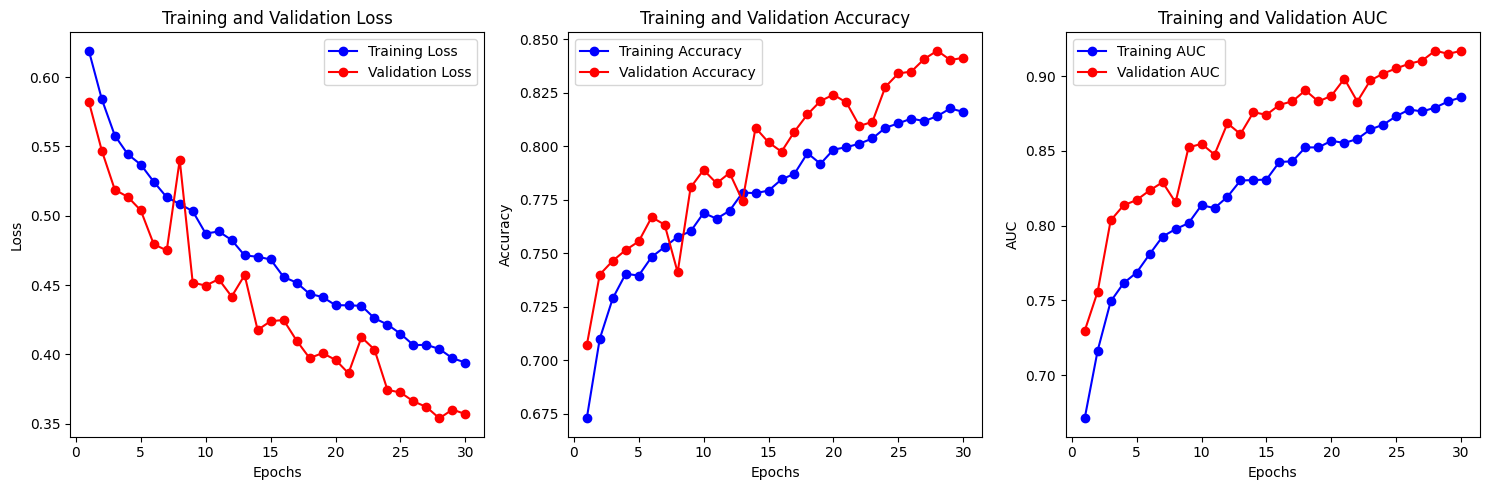

In [14]:
# Visualize the Training Results 

import matplotlib.pyplot as plt

def plot_training_history(history):
    # Get the training and validation metrics
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    train_auc = history.history['auc']
    val_auc = history.history['val_auc']
    
    epochs = range(1, len(train_loss) + 1)
    
    # Create figure with subplots
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot AUC
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_auc, 'bo-', label='Training AUC')
    plt.plot(epochs, val_auc, 'ro-', label='Validation AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(ROOT_DIR, 'training_plots.png'))
    plt.show()

# Plot the training history
plot_training_history(history)


In [18]:
# Save the model

model_path = os.path.join(MODEL_SAVE_DIR, 'glaucoma_detection_model.h5')
model.save(model_path)
print(f"Model saved successfully at: {model_path}")

Model saved successfully at: C:/Users/ASUS/Downloads/Model Training/model\glaucoma_detection_model.h5


In [20]:
# Save the model in TensorFlow SavedModel format (saved as optional if needed for deployment)

saved_model_path = os.path.join(MODEL_SAVE_DIR, 'glaucoma_detection_model.keras')
model.save(saved_model_path)
print(f"Model saved successfully at: {saved_model_path}")

Model saved successfully at: C:/Users/ASUS/Downloads/Model Training/model\glaucoma_detection_model.keras


In [22]:
# Create a simple function to test the model with a test image

def predict_glaucoma(image_path, model):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256))
    img = custom_preprocessing(img)
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    
    # Make prediction
    prediction = model.predict(img)
    probability = prediction[0][0]
    
    # Classify based on probability
    if probability >= 0.5:
        result = "Glaucoma Present"
        class_label = 1
    else:
        result = "No Glaucoma"
        class_label = 0
        
    return {
        "class": class_label,
        "probability": float(probability),
        "result": result
    }

# Example:
test_image_path = os.path.join(ROOT_DIR, "test/0/BEH-629.png")
result = predict_glaucoma(test_image_path, model)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
{'class': 0, 'probability': 0.08402750641107559, 'result': 'No Glaucoma'}


In [25]:
# Create a simple function to test the model with a test image

def predict_glaucoma(image_path, model):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256))
    img = custom_preprocessing(img)
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    
    # Make prediction
    prediction = model.predict(img)
    probability = prediction[0][0]
    
    # Classify based on probability
    if probability >= 0.5:
        result = "Glaucoma Present"
        class_label = 1
    else:
        result = "No Glaucoma"
        class_label = 0
        
    return {
        "class": class_label,
        "probability": float(probability),
        "result": result
    }

# Example:
test_image_path = os.path.join(ROOT_DIR, "test/1/PAPILA-49.png")
result = predict_glaucoma(test_image_path, model)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
{'class': 1, 'probability': 0.6900932192802429, 'result': 'Glaucoma Present'}


Loading model from: C:/Users/ASUS/Downloads/Model Training/model\glaucoma_detection_model.h5


Model loaded successfully

==== Testing Model with Sample Images ====

Testing image (expected class: 0 (No Glaucoma)):
Loading image from: C:/Users/ASUS/Downloads/Model Training\test/0/BEH-629.png
Image resized to: (256, 256, 3)
Custom preprocessing applied
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
Raw prediction value: 0.08402750641107559
Prediction Result:
  class: 0
  probability: 0.08402750641107559
  result: No Glaucoma
--------------------------------------------------
Testing image (expected class: 1 (Glaucoma Present)):
Loading image from: C:/Users/ASUS/Downloads/Model Training\test/1/PAPILA-49.png
Image resized to: (256, 256, 3)
Custom preprocessing applied
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Raw prediction value: 0.6900932192802429
Prediction Result:
  class: 1
  probability: 0.6900932192802429
  result: Glaucoma Present
--------------------------------------------------
Loading image from: C:/Users/ASUS/Downloads/Model Training\test/0/BEH-629.png
Image resized to: (256, 256,

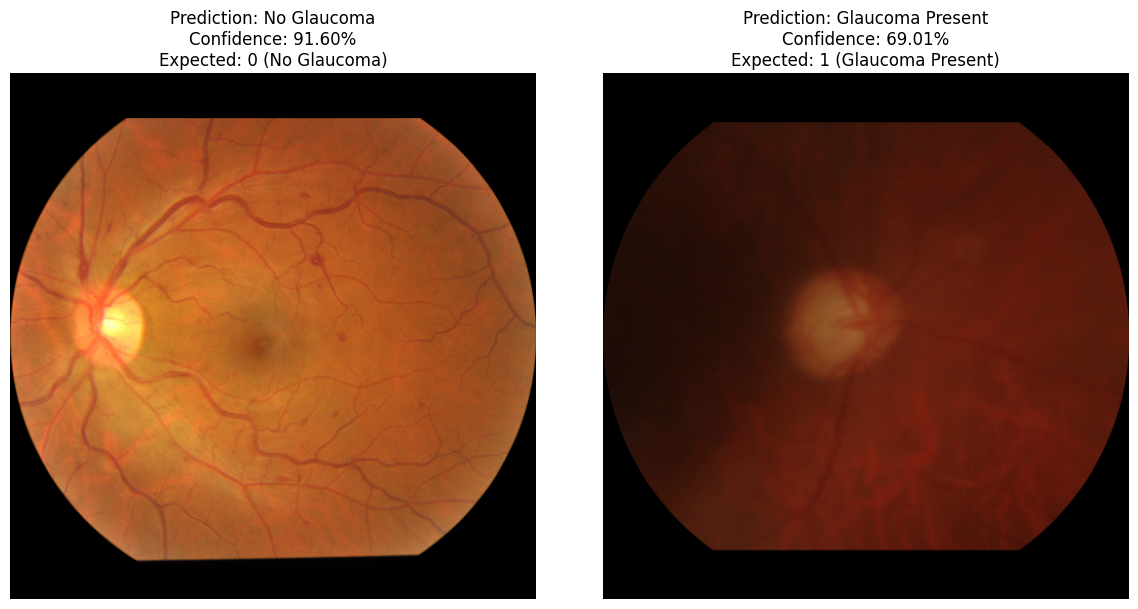

Model testing completed.


In [26]:
# Test the model with sample images

import os
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Define the custom preprocessing function
def custom_preprocessing(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(gray_image, (65, 65), 0)
    
    # Find the pixel with the highest intensity value
    max_intensity_pixel = np.unravel_index(np.argmax(blurred_image), blurred_image.shape)
    
    # Define the radius for the circle
    radius = 200 // 2
    
    # Get the x and y coordinates for cropping the image
    x = max_intensity_pixel[1] - radius
    y = max_intensity_pixel[0] - radius
    
    # Create a mask for the circle
    mask = np.zeros_like(image)
    cv2.circle(mask, (x + radius, y + radius), radius, (255, 255, 255), -1)
    
    # Apply the mask to the original image
    roi_image = cv2.bitwise_and(image, mask)
    
    # Split the green channel
    green_channel = roi_image[:, :, 1]
    
    # Apply histogram equalization
    clahe_op = cv2.createCLAHE(clipLimit=2)
    roi_image = clahe_op.apply(green_channel)
    
    # Reshape to 3 channels for model input
    roi_image = cv2.cvtColor(roi_image, cv2.COLOR_GRAY2RGB)
    
    return roi_image

# Function to predict glaucoma from a retinal image
def predict_glaucoma(image_path, model):
    # Load the image
    print(f"Loading image from: {image_path}")
    img = cv2.imread(image_path)
    
    # Resize image to match model input size
    img = cv2.resize(img, (256, 256))
    print("Image resized to:", img.shape)
    
    # Apply custom preprocessing
    img = custom_preprocessing(img)
    print("Custom preprocessing applied")
    
    # Normalize pixel values to 0-1 range
    img = img / 255.0
    
    # Add batch dimension (model expects batch input)
    img = np.expand_dims(img, axis=0)
    
    # Make prediction
    prediction = model.predict(img, verbose=1)
    probability = float(prediction[0][0])
    print(f"Raw prediction value: {probability}")
    
    # Classify based on probability threshold
    if probability >= 0.5:
        result = "Glaucoma Present"
        class_label = 1
    else:
        result = "No Glaucoma"
        class_label = 0
        
    # Return results
    return {
        "class": class_label,
        "probability": probability,
        "result": result
    }

# Load the saved model
model_path = os.path.join(MODEL_SAVE_DIR, 'glaucoma_detection_model.h5')
print(f"Loading model from: {model_path}")

model = load_model(model_path)
print("Model loaded successfully")

# Define paths for test images ( I have picked one from glaucoma-0 and one from non-glaucoma -1 folders)
img0_path = os.path.join(ROOT_DIR, "test/0/BEH-629.png")     # non-glaucoma
img1_path = os.path.join(ROOT_DIR, "test/1/PAPILA-49.png")   # glaucoma

# Create sample images list with fixed paths
sample_images = [
    {
        "path": img0_path,
        "expected_class": "0 (No Glaucoma)"
    },
    {
        "path": img1_path,
        "expected_class": "1 (Glaucoma Present)"
    }
]

# Test the model with the sample images
print("\n==== Testing Model with Sample Images ====\n")
for sample in sample_images:
    print(f"Testing image (expected class: {sample['expected_class']}):")
    result = predict_glaucoma(sample["path"], model)
    print("Prediction Result:")
    for key, value in result.items():
        print(f"  {key}: {value}")
    print("-"*50)

# Visualize sample images and predictions
plt.figure(figsize=(12, 6))

for i, sample in enumerate(sample_images):
    # Load and display the image
    img = cv2.imread(sample["path"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get prediction
    result = predict_glaucoma(sample["path"], model)
    
    # Display image with prediction
    plt.subplot(1, 2, i+1)
    plt.imshow(img)
    
    # Add title with prediction
    confidence = result["probability"] if result["class"] == 1 else 1 - result["probability"]
    plt.title(f"Prediction: {result['result']}\nConfidence: {confidence:.2%}\nExpected: {sample['expected_class']}")
    plt.axis('off')

plt.tight_layout()
plt.show()

print("Model testing completed.")